- Dependencies:
    pip install decord

1. Download the Dataset: I used MSR-VTT as it's the smallest dataset in the downstream task. For example, all videos are stored in: /media/drive2/Data_4TB/MSRVTT/videos/all
https://github.com/showlab/all-in-one/blob/main/DATA.md

2. Creat a file list, that contains all names of the videos for extraction. Use the following script.

3. Extract Dense Flow using RAFT: https://github.com/princeton-vl/RAFT

    git clone https://github.com/princeton-vl/RAFT.git

4. Extract frames from videos, and save neighboring images also their extracted optical flow.

In [86]:
import os

MSR_VTT_PATH = '/media/drive2/Data_4TB/MSRVTT'
VIDEO_PATH = '/media/drive2/Data_4TB/MSRVTT/videos/all'


# list all videos
video_list = set()
for video in os.listdir(VIDEO_PATH):
    if video.endswith('.mp4'):
        video_list.add(os.path.join(VIDEO_PATH, video))

# write to a file
with open(os.path.join(MSR_VTT_PATH, 'MSR-VTT_video_lists.txt'), 'w') as f:
    for item in video_list:
        f.write("%s\n" % item)

print('Number of videos: {}'.format(len(video_list)))

Number of videos: 10003


In [1]:
# Model Initialization and weight loading
import sys
sys.path.append('RAFT/core')

import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
import matplotlib.pyplot as plt
from collections import namedtuple
from utils.utils import InputPadder

DEVICE = 'cuda'

    
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
args = {}
args['model'] = '/media/drive2/Data_4TB/MSRVTT/RAFT/models/raft-things.pth'
args['mixed_precision'] = True
args['small'] = False
args = AttributeDict(args)

model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()
print('RAFT Loaded.')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# This is out of my expectation, RAFT has just 5M parameters,
# we probably can consider merge this network into the VL model.
count_parameters(model)

RAFT Loaded.


5257536

In [26]:
import os
import cv2
import tqdm
import logging
import numpy as np
from PIL import Image
from decord import cpu, gpu
from decord import VideoReader
from numpy import save, load


################################ Helper Function ################################

# Convert the numpy array to tensor
def load_image(imfile):
    img = np.array(imfile).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


# Convert the numpy array to save as PIL image
def array_to_image(array, img_name):
    PIL_image = Image.fromarray(array.astype('uint8'), 'RGB')
    PIL_image.save(img_name)

    
# Compute the Optical-flow and Image sample margin
def compute_fps_sample(vid_length, vid_fps, fr_fps, of_fps, FIXED_FRAME=None, FIXED_FLOW=None):
    '''
        vid_length: total frames of the raw video
        vid_fps: int, FPS of the raw video
        fr_fps:  desired sampling FPS for storing frames
        of_fps:  desired samlping Optical flow FPS for compute OF
    '''
    if not FIXED_FRAME:
        fr_every = round(vid_fps/fr_fps)
    else:
        fr_every = round(vid_length/FIXED_FRAME)
    
    if not FIXED_FLOW:
        of_every = round(vid_fps/of_fps)
    else:
        of_every = round(vid_length/FIXED_FLOW)
    
    return fr_every, of_every
    

# Create the directory for video
def create_dir(vid_dir):
            
    vid_of_dir = os.path.join(vid_dir, 'optical_flows')
    vid_fr_dir =os.path.join(vid_dir, 'frames')
        
    if not os.path.exists(vid_dir):
        os.makedirs(vid_dir)
        os.makedirs(vid_of_dir)
        os.makedirs(vid_fr_dir)
        return vid_fr_dir, vid_of_dir
    
    # already extracted, skip
    else:
        return False, False
        

# Visualize the Optical Flow
def viz(img, flo, display=True):
    '''
        img: numpy array
        flo: numpy array, H, W, 2
    '''
    img = img[0].permute(1, 2, 0).cpu().numpy()
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    
    if display:
        figure(figsize=(11, 11), dpi=80)
        plt.imshow(img_flo / 255.0)
        plt.show()
    
    return img_flo / 255.0


# Open Video stream
def open_video(video_path):
    
    # Handle the pre/post-fix, this might differ on different datasets.
    if '\n' in VIDEO_LIST[0]:
        prefix = '/videos/all'
        postfix = '.mp4\n'

    else:
        prefix = '/videos/all'  
        postfix = '.mp4'

    vid_idx = video_path[video_path.index(prefix)+len(prefix)+1:-len(postfix)]
    video_path = video_path[:-1]

    # Open the video stream
    vid_stream = VideoReader(video_path, ctx=cpu(0))
    vid_length = len(vid_stream)
    fps = vid_stream.get_avg_fps()

    return vid_idx, vid_stream, vid_length, fps


def frame_sample(vid_length, sample_every):
    frame_idx = 0
    sample_list = []
    
    while frame_idx < vid_length:

        if frame_idx % sample_every == 0:
            sample_list.append(frame_idx)

        frame_idx += 1
    
    return sample_list

In [28]:
# Extract the frames
def store_frames(video_path, FR_EVERY, vid_stream, vid_length, fps, vid_fr_dir):

    # Frame idx that we are sampling
    frame_list = frame_sample(vid_length, FR_EVERY)

    # Sample every few frames
    frames = vid_stream.get_batch(frame_list).asnumpy()
    
    # Store the frames
    for idx, frame in zip(frame_list, frames):
        fr_file = '{}_'.format(vid_idx) + str(idx) + '.jpg'
        array_to_image(frame, os.path.join(vid_fr_dir, fr_file))
    
    print('Done video frame extraction {}'.format(vid_idx))

    
# Compute flow
def compute_flows(video_path, SAMPLE_EVERY, vid_stream, vid_length, fps, vid_of_dir, FLOW_TYPE=np.uint8):

    # Optical flow saving to the list
    of_list = [] 
    
    flow_list = frame_sample(vid_length, SAMPLE_EVERY)

    # Extract Optical Flow at the sampling case
 
    # Re-organize list, applend the next frame for flow computation
    tmp = []
    for idx in flow_list:
        if idx < vid_length-1:
            tmp.append(idx)
            tmp.append(idx+1)

    flow_list = tmp

    # Load the image
    frames = vid_stream.get_batch(flow_list).asnumpy()

    # RAFT model inference, currently we didn't use batch inference, still two frames per iter.
    with torch.no_grad():
        
        # Use every two frames
        for idx in range(0, len(flow_list), 2):

            image1 = load_image(frames[idx])
            image2 = load_image(frames[idx+1])

            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)

            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

            # Append the flow
            flow_up = (flow_up[0].permute(1, 2, 0).unsqueeze(0)).detach().cpu().numpy()
            of_list.append(flow_up)

    # Save the Optical flow into NPY file: FRAME x H x W x 2
    of_file = '{}'.format(vid_idx)+'.npy'
    if of_list:

        # Quantization
        if FLOW_TYPE == np.uint8:
            flow = (np.concatenate(of_list, axis=0)*255.0).astype(FLOW_TYPE)
        else:
            flow = np.concatenate(of_list, axis=0).astype(FLOW_TYPE)

        save(os.path.join(vid_of_dir, of_file), flow)

    of_list = []

    print('Done Flow Computation, video {}'.format(vid_idx))
    
################################ Main Script ################################

# File that contains all video list
VIDEO_LIST_file = '/media/drive2/Data_4TB/MSRVTT/MSR-VTT_video_lists.txt' 
STORE_DIR = '/media/drive2/Data_4TB/MSRVTT/videos/frames/5fps'

# Read all video path
VIDEO_LIST = open(VIDEO_LIST_file, "r").readlines()     

# Store frame(s)/Compute Optical Flows every second
FRAME_FPS, FLOW_FPS = 1.0, 2.0    
FIXED_FRAME = 8
FIXED_FLOW = None

# Type of flow storage, float32 or uint8, if using uint8, then we using compressed optical flow array
FLOW_TYPE = np.uint8       

# for video_path in VIDEO_LIST[:10]:
for video_path in VIDEO_LIST:
    
    # Get video-stream, and video_length, video_fps
    vid_idx, vid_stream, vid_length, fps = open_video(video_path)

    # if the video exist and read successfully
    if vid_length <= 0:    continue
    
    # Create video path, store in the format: video_idx/frames, video_idx/optical_flows
    vid_fr_dir, vid_of_dir = create_dir(os.path.join(STORE_DIR, vid_idx))
    
    # Skip the existed video
    if not vid_fr_dir and not vid_of_dir:  continue
        
    # Sampling every few frames
    FR_EVERY, FLOW_EVERY = compute_fps_sample(vid_length, fps, FRAME_FPS, FLOW_FPS, FIXED_FRAME, FIXED_FLOW)
    
    store_frames(video_path, FR_EVERY, vid_stream, vid_length, fps, vid_fr_dir)
    
    compute_flows(video_path, FLOW_EVERY, vid_stream, vid_length, fps, vid_of_dir, FLOW_TYPE=FLOW_TYPE)


Done video frame extraction video7499
Done Flow Computation, video video7499
Done video frame extraction video7701
Done Flow Computation, video video7701
Done video frame extraction video3376
Done Flow Computation, video video3376
Done video frame extraction video9647
Done Flow Computation, video video9647
Done video frame extraction video7020
Done Flow Computation, video video7020
Done video frame extraction video1254
Done Flow Computation, video video1254
Done video frame extraction video8712
Done Flow Computation, video video8712
Done video frame extraction video2800
Done Flow Computation, video video2800
Done video frame extraction video9747
Done Flow Computation, video video9747
Done video frame extraction video8398
Done Flow Computation, video video8398
Done video frame extraction video8523
Done Flow Computation, video video8523
Done video frame extraction video358
Done Flow Computation, video video358
Done video frame extraction video8356
Done Flow Computation, video video8356
D

Done video frame extraction video6880
Done Flow Computation, video video6880
Done video frame extraction video3945
Done Flow Computation, video video3945
Done video frame extraction video2930
Done Flow Computation, video video2930
Done video frame extraction video5261
Done Flow Computation, video video5261
Done video frame extraction video6563
Done Flow Computation, video video6563
Done video frame extraction video2262
Done Flow Computation, video video2262
Done video frame extraction video2936
Done Flow Computation, video video2936
Done video frame extraction video1050
Done Flow Computation, video video1050
Done video frame extraction video2143
Done Flow Computation, video video2143
Done video frame extraction video1103
Done Flow Computation, video video1103
Done video frame extraction video5612
Done Flow Computation, video video5612
Done video frame extraction video2862
Done Flow Computation, video video2862
Done video frame extraction video5872
Done Flow Computation, video video5872

Done Flow Computation, video video5993
Done video frame extraction video6852
Done Flow Computation, video video6852
Done video frame extraction video7745
Done Flow Computation, video video7745
Done video frame extraction video8276
Done Flow Computation, video video8276
Done video frame extraction video2021
Done Flow Computation, video video2021
Done video frame extraction video1503
Done Flow Computation, video video1503
Done video frame extraction video2565
Done Flow Computation, video video2565
Done video frame extraction video1054
Done Flow Computation, video video1054
Done video frame extraction video307
Done Flow Computation, video video307
Done video frame extraction video8752
Done Flow Computation, video video8752
Done video frame extraction video228
Done Flow Computation, video video228
Done video frame extraction video7601
Done Flow Computation, video video7601
Done video frame extraction video6158
Done Flow Computation, video video6158
Done video frame extraction video6294
Don

Done Flow Computation, video video2439
Done video frame extraction video5152
Done Flow Computation, video video5152
Done video frame extraction video2718
Done Flow Computation, video video2718
Done video frame extraction video7269
Done Flow Computation, video video7269
Done video frame extraction video351
Done Flow Computation, video video351
Done video frame extraction video316
Done Flow Computation, video video316
Done video frame extraction video2179
Done Flow Computation, video video2179
Done video frame extraction video7220
Done Flow Computation, video video7220
Done video frame extraction video4483
Done Flow Computation, video video4483
Done video frame extraction video5599
Done Flow Computation, video video5599
Done video frame extraction video7300
Done Flow Computation, video video7300
Done video frame extraction video3277
Done Flow Computation, video video3277
Done video frame extraction video4101
Done Flow Computation, video video4101
Done video frame extraction video2247
Don

Done Flow Computation, video video7911
Done video frame extraction video8605
Done Flow Computation, video video8605
Done video frame extraction video218
Done Flow Computation, video video218
Done video frame extraction video6378
Done Flow Computation, video video6378
Done video frame extraction video9459
Done Flow Computation, video video9459
Done video frame extraction video6971
Done Flow Computation, video video6971
Done video frame extraction video2019
Done Flow Computation, video video2019
Done video frame extraction video1214
Done Flow Computation, video video1214
Done video frame extraction video3383
Done Flow Computation, video video3383
Done video frame extraction video653
Done Flow Computation, video video653
Done video frame extraction video6157
Done Flow Computation, video video6157
Done video frame extraction video656
Done Flow Computation, video video656
Done video frame extraction video8654
Done Flow Computation, video video8654
Done video frame extraction video6473
Done 

Done Flow Computation, video video4118
Done video frame extraction video4627
Done Flow Computation, video video4627
Done video frame extraction video1744
Done Flow Computation, video video1744
Done video frame extraction video5999
Done Flow Computation, video video5999
Done video frame extraction video7084
Done Flow Computation, video video7084
Done video frame extraction video1252
Done Flow Computation, video video1252
Done video frame extraction video1006
Done Flow Computation, video video1006
Done video frame extraction video8173
Done Flow Computation, video video8173
Done video frame extraction video8713
Done Flow Computation, video video8713
Done video frame extraction video1342
Done Flow Computation, video video1342
Done video frame extraction video8771
Done Flow Computation, video video8771
Done video frame extraction video2257
Done Flow Computation, video video2257
Done video frame extraction video7159
Done Flow Computation, video video7159
Done video frame extraction video6934

Done Flow Computation, video video8312
Done video frame extraction video4112
Done Flow Computation, video video4112
Done video frame extraction video1885
Done Flow Computation, video video1885
Done video frame extraction video9117
Done Flow Computation, video video9117
Done video frame extraction video8005
Done Flow Computation, video video8005
Done video frame extraction video2681
Done Flow Computation, video video2681
Done video frame extraction video440
Done Flow Computation, video video440
Done video frame extraction video7636
Done Flow Computation, video video7636
Done video frame extraction video6647
Done Flow Computation, video video6647
Done video frame extraction video3598
Done Flow Computation, video video3598
Done video frame extraction video4400
Done Flow Computation, video video4400
Done video frame extraction video2931
Done Flow Computation, video video2931
Done video frame extraction video7950
Done Flow Computation, video video7950
Done video frame extraction video2333
D

Done Flow Computation, video video3044
Done video frame extraction video898
Done Flow Computation, video video898
Done video frame extraction video8257
Done Flow Computation, video video8257
Done video frame extraction video6404
Done Flow Computation, video video6404
Done video frame extraction video9254
Done Flow Computation, video video9254
Done video frame extraction video1088
Done Flow Computation, video video1088
Done video frame extraction video9520
Done Flow Computation, video video9520
Done video frame extraction video3324
Done Flow Computation, video video3324
Done video frame extraction video4726
Done Flow Computation, video video4726
Done video frame extraction video1319
Done Flow Computation, video video1319
Done video frame extraction video6553
Done Flow Computation, video video6553
Done video frame extraction video6011
Done Flow Computation, video video6011
Done video frame extraction video1513
Done Flow Computation, video video1513
Done video frame extraction video8537
D

Done Flow Computation, video video3574
Done video frame extraction video1914
Done Flow Computation, video video1914
Done video frame extraction video7014
Done Flow Computation, video video7014
Done video frame extraction video1496
Done Flow Computation, video video1496
Done video frame extraction video5733
Done Flow Computation, video video5733
Done video frame extraction video2648
Done Flow Computation, video video2648
Done video frame extraction video1043
Done Flow Computation, video video1043
Done video frame extraction video2287
Done Flow Computation, video video2287
Done video frame extraction video3399
Done Flow Computation, video video3399
Done video frame extraction video8187
Done Flow Computation, video video8187
Done video frame extraction video8595
Done Flow Computation, video video8595
Done video frame extraction video642
Done Flow Computation, video video642
Done video frame extraction video6982
Done Flow Computation, video video6982
Done video frame extraction video9863
D

Done Flow Computation, video video4319
Done video frame extraction video6357
Done Flow Computation, video video6357
Done video frame extraction video5479
Done Flow Computation, video video5479
Done video frame extraction video8065
Done Flow Computation, video video8065
Done video frame extraction video7109
Done Flow Computation, video video7109
Done video frame extraction video4329
Done Flow Computation, video video4329
Done video frame extraction video8092
Done Flow Computation, video video8092
Done video frame extraction video7193
Done Flow Computation, video video7193
Done video frame extraction video457
Done Flow Computation, video video457
Done video frame extraction video5888
Done Flow Computation, video video5888
Done video frame extraction video1637
Done Flow Computation, video video1637
Done video frame extraction video6478
Done Flow Computation, video video6478
Done video frame extraction video2128
Done Flow Computation, video video2128
Done video frame extraction video2992
D

Done Flow Computation, video video7121
Done video frame extraction video2003
Done Flow Computation, video video2003
Done video frame extraction video4337
Done Flow Computation, video video4337
Done video frame extraction video3204
Done Flow Computation, video video3204
Done video frame extraction video6704
Done Flow Computation, video video6704
Done video frame extraction video149
Done Flow Computation, video video149
Done video frame extraction video1606
Done Flow Computation, video video1606
Done video frame extraction video4388
Done Flow Computation, video video4388
Done video frame extraction video9924
Done Flow Computation, video video9924
Done video frame extraction video3929
Done Flow Computation, video video3929
Done video frame extraction video8428
Done Flow Computation, video video8428
Done video frame extraction video1414
Done Flow Computation, video video1414
Done video frame extraction video2486
Done Flow Computation, video video2486
Done video frame extraction video5409
D

Done Flow Computation, video video7782
Done video frame extraction video3449
Done Flow Computation, video video3449
Done video frame extraction video1652
Done Flow Computation, video video1652
Done video frame extraction video6222
Done Flow Computation, video video6222
Done video frame extraction video5391
Done Flow Computation, video video5391
Done video frame extraction video6987
Done Flow Computation, video video6987
Done video frame extraction video6091
Done Flow Computation, video video6091
Done video frame extraction video3259
Done Flow Computation, video video3259
Done video frame extraction video5210
Done Flow Computation, video video5210
Done video frame extraction video3927
Done Flow Computation, video video3927
Done video frame extraction video902
Done Flow Computation, video video902
Done video frame extraction video2347
Done Flow Computation, video video2347
Done video frame extraction video1701
Done Flow Computation, video video1701
Done video frame extraction video3757
D

Done Flow Computation, video video5586
Done video frame extraction video5123
Done Flow Computation, video video5123
Done video frame extraction video4780
Done Flow Computation, video video4780
Done video frame extraction video7977
Done Flow Computation, video video7977
Done video frame extraction video7561
Done Flow Computation, video video7561
Done video frame extraction video2501
Done Flow Computation, video video2501
Done video frame extraction video8936
Done Flow Computation, video video8936
Done video frame extraction video4948
Done Flow Computation, video video4948
Done video frame extraction video5894
Done Flow Computation, video video5894
Done video frame extraction video2711
Done Flow Computation, video video2711
Done video frame extraction video5696
Done Flow Computation, video video5696
Done video frame extraction video7827
Done Flow Computation, video video7827
Done video frame extraction video9808
Done Flow Computation, video video9808
Done video frame extraction video9100

Done Flow Computation, video video5838
Done video frame extraction video8944
Done Flow Computation, video video8944
Done video frame extraction video3997
Done Flow Computation, video video3997
Done video frame extraction video8254
Done Flow Computation, video video8254
Done video frame extraction video6940
Done Flow Computation, video video6940
Done video frame extraction video4550
Done Flow Computation, video video4550
Done video frame extraction video4177
Done Flow Computation, video video4177
Done video frame extraction video6239
Done Flow Computation, video video6239
Done video frame extraction video8893
Done Flow Computation, video video8893
Done video frame extraction video7368
Done Flow Computation, video video7368
Done video frame extraction video9577
Done Flow Computation, video video9577
Done video frame extraction video2318
Done Flow Computation, video video2318
Done video frame extraction video7015
Done Flow Computation, video video7015
Done video frame extraction video6114

Done Flow Computation, video video1110
Done video frame extraction video2509
Done Flow Computation, video video2509
Done video frame extraction video6556
Done Flow Computation, video video6556
Done video frame extraction video3624
Done Flow Computation, video video3624
Done video frame extraction video5683
Done Flow Computation, video video5683
Done video frame extraction video4970
Done Flow Computation, video video4970
Done video frame extraction video5016
Done Flow Computation, video video5016
Done video frame extraction video7024
Done Flow Computation, video video7024
Done video frame extraction video1489
Done Flow Computation, video video1489
Done video frame extraction video772
Done Flow Computation, video video772
Done video frame extraction video7418
Done Flow Computation, video video7418
Done video frame extraction video1278
Done Flow Computation, video video1278
Done video frame extraction video3340
Done Flow Computation, video video3340
Done video frame extraction video8300
D

Done Flow Computation, video video2099
Done video frame extraction video2941
Done Flow Computation, video video2941
Done video frame extraction video7616
Done Flow Computation, video video7616
Done video frame extraction video7465
Done Flow Computation, video video7465
Done video frame extraction video6945
Done Flow Computation, video video6945
Done video frame extraction video7164
Done Flow Computation, video video7164
Done video frame extraction video2760
Done Flow Computation, video video2760
Done video frame extraction video6770
Done Flow Computation, video video6770
Done video frame extraction video3302
Done Flow Computation, video video3302
Done video frame extraction video990
Done Flow Computation, video video990
Done video frame extraction video2645
Done Flow Computation, video video2645
Done video frame extraction video2135
Done Flow Computation, video video2135
Done video frame extraction video1493
Done Flow Computation, video video1493
Done video frame extraction video912
Do

Done Flow Computation, video video395
Done video frame extraction video918
Done Flow Computation, video video918
Done video frame extraction video4291
Done Flow Computation, video video4291
Done video frame extraction video9619
Done Flow Computation, video video9619
Done video frame extraction video873
Done Flow Computation, video video873
Done video frame extraction video7187
Done Flow Computation, video video7187
Done video frame extraction video9224
Done Flow Computation, video video9224
Done video frame extraction video8755
Done Flow Computation, video video8755
Done video frame extraction video3670
Done Flow Computation, video video3670
Done video frame extraction video7494
Done Flow Computation, video video7494
Done video frame extraction video9185
Done Flow Computation, video video9185
Done video frame extraction video7099
Done Flow Computation, video video7099
Done video frame extraction video1629
Done Flow Computation, video video1629
Done video frame extraction video694
Done 

Done Flow Computation, video video9476
Done video frame extraction video2974
Done Flow Computation, video video2974
Done video frame extraction video3100
Done Flow Computation, video video3100
Done video frame extraction video449
Done Flow Computation, video video449
Done video frame extraction video8006
Done Flow Computation, video video8006
Done video frame extraction video4215
Done Flow Computation, video video4215
Done video frame extraction video1990
Done Flow Computation, video video1990
Done video frame extraction video8245
Done Flow Computation, video video8245
Done video frame extraction video4505
Done Flow Computation, video video4505
Done video frame extraction video3532
Done Flow Computation, video video3532
Done video frame extraction video4237
Done Flow Computation, video video4237
Done video frame extraction video7618
Done Flow Computation, video video7618
Done video frame extraction video950
Done Flow Computation, video video950
Done video frame extraction video5708
Don

Done Flow Computation, video video9618
Done video frame extraction video2792
Done Flow Computation, video video2792
Done video frame extraction video6362
Done Flow Computation, video video6362
Done video frame extraction video5598
Done Flow Computation, video video5598
Done video frame extraction video553
Done Flow Computation, video video553
Done video frame extraction video14
Done Flow Computation, video video14
Done video frame extraction video1089
Done Flow Computation, video video1089
Done video frame extraction video1756
Done Flow Computation, video video1756
Done video frame extraction video6433
Done Flow Computation, video video6433
Done video frame extraction video4089
Done Flow Computation, video video4089
Done video frame extraction video5738
Done Flow Computation, video video5738
Done video frame extraction video4639
Done Flow Computation, video video4639
Done video frame extraction video7130
Done Flow Computation, video video7130
Done video frame extraction video4943
Done 

Done Flow Computation, video video138
Done video frame extraction video8143
Done Flow Computation, video video8143
Done video frame extraction video8680
Done Flow Computation, video video8680
Done video frame extraction video2114
Done Flow Computation, video video2114
Done video frame extraction video3767
Done Flow Computation, video video3767
Done video frame extraction video2239
Done Flow Computation, video video2239
Done video frame extraction video9102
Done Flow Computation, video video9102
Done video frame extraction video1840
Done Flow Computation, video video1840
Done video frame extraction video6016
Done Flow Computation, video video6016
Done video frame extraction video7359
Done Flow Computation, video video7359
Done video frame extraction video5640
Done Flow Computation, video video5640
Done video frame extraction video7107
Done Flow Computation, video video7107
Done video frame extraction video6097
Done Flow Computation, video video6097
Done video frame extraction video1780


Done Flow Computation, video video2195
Done video frame extraction video9168
Done Flow Computation, video video9168
Done video frame extraction video3610
Done Flow Computation, video video3610
Done video frame extraction video8506
Done Flow Computation, video video8506
Done video frame extraction video2697
Done Flow Computation, video video2697
Done video frame extraction video3112
Done Flow Computation, video video3112
Done video frame extraction video2358
Done Flow Computation, video video2358
Done video frame extraction video5057
Done Flow Computation, video video5057
Done video frame extraction video9375
Done Flow Computation, video video9375
Done video frame extraction video8664
Done Flow Computation, video video8664
Done video frame extraction video437
Done Flow Computation, video video437
Done video frame extraction video1449
Done Flow Computation, video video1449
Done video frame extraction video9421
Done Flow Computation, video video9421
Done video frame extraction video6038
D

Done Flow Computation, video video506
Done video frame extraction video1541
Done Flow Computation, video video1541
Done video frame extraction video6253
Done Flow Computation, video video6253
Done video frame extraction video5912
Done Flow Computation, video video5912
Done video frame extraction video7500
Done Flow Computation, video video7500
Done video frame extraction video9672
Done Flow Computation, video video9672
Done video frame extraction video9463
Done Flow Computation, video video9463
Done video frame extraction video6285
Done Flow Computation, video video6285
Done video frame extraction video5694
Done Flow Computation, video video5694
Done video frame extraction video7253
Done Flow Computation, video video7253
Done video frame extraction video5626
Done Flow Computation, video video5626
Done video frame extraction video8238
Done Flow Computation, video video8238
Done video frame extraction video456
Done Flow Computation, video video456
Done video frame extraction video4628
Do

Done Flow Computation, video video9425
Done video frame extraction video3828
Done Flow Computation, video video3828
Done video frame extraction video2479
Done Flow Computation, video video2479
Done video frame extraction video546
Done Flow Computation, video video546
Done video frame extraction video8498
Done Flow Computation, video video8498
Done video frame extraction video6882
Done Flow Computation, video video6882
Done video frame extraction video9419
Done Flow Computation, video video9419
Done video frame extraction video6456
Done Flow Computation, video video6456
Done video frame extraction video4320
Done Flow Computation, video video4320
Done video frame extraction video2291
Done Flow Computation, video video2291
Done video frame extraction video738
Done Flow Computation, video video738
Done video frame extraction video8757
Done Flow Computation, video video8757
Done video frame extraction video8293
Done Flow Computation, video video8293
Done video frame extraction video9314
Don

Done Flow Computation, video video5706
Done video frame extraction video3765
Done Flow Computation, video video3765
Done video frame extraction video6353
Done Flow Computation, video video6353
Done video frame extraction video2403
Done Flow Computation, video video2403
Done video frame extraction video6561
Done Flow Computation, video video6561
Done video frame extraction video7455
Done Flow Computation, video video7455
Done video frame extraction video3913
Done Flow Computation, video video3913
Done video frame extraction video606
Done Flow Computation, video video606
Done video frame extraction video2871
Done Flow Computation, video video2871
Done video frame extraction video9234
Done Flow Computation, video video9234
Done video frame extraction video5500
Done Flow Computation, video video5500
Done video frame extraction video6044
Done Flow Computation, video video6044
Done video frame extraction video1475
Done Flow Computation, video video1475
Done video frame extraction video6181
D

Done Flow Computation, video video7258
Done video frame extraction video8829
Done Flow Computation, video video8829
Done video frame extraction video8129
Done Flow Computation, video video8129
Done video frame extraction video8377
Done Flow Computation, video video8377
Done video frame extraction video504
Done Flow Computation, video video504
Done video frame extraction video3215
Done Flow Computation, video video3215
Done video frame extraction video9456
Done Flow Computation, video video9456
Done video frame extraction video6407
Done Flow Computation, video video6407
Done video frame extraction video2744
Done Flow Computation, video video2744
Done video frame extraction video4991
Done Flow Computation, video video4991
Done video frame extraction video4389
Done Flow Computation, video video4389
Done video frame extraction video1165
Done Flow Computation, video video1165
Done video frame extraction video8806
Done Flow Computation, video video8806
Done video frame extraction video3974
D

Done Flow Computation, video video3956
Done video frame extraction video5625
Done Flow Computation, video video5625
Done video frame extraction video7115
Done Flow Computation, video video7115
Done video frame extraction video5964
Done Flow Computation, video video5964
Done video frame extraction video5326
Done Flow Computation, video video5326
Done video frame extraction video9884
Done Flow Computation, video video9884
Done video frame extraction video7589
Done Flow Computation, video video7589
Done video frame extraction video8527
Done Flow Computation, video video8527
Done video frame extraction video6670
Done Flow Computation, video video6670
Done video frame extraction video8021
Done Flow Computation, video video8021
Done video frame extraction video2411
Done Flow Computation, video video2411
Done video frame extraction video1412
Done Flow Computation, video video1412
Done video frame extraction video9854
Done Flow Computation, video video9854
Done video frame extraction video5242

Done Flow Computation, video video6917
Done video frame extraction video1682
Done Flow Computation, video video1682
Done video frame extraction video1141
Done Flow Computation, video video1141
Done video frame extraction video9536
Done Flow Computation, video video9536
Done video frame extraction video8613
Done Flow Computation, video video8613
Done video frame extraction video5949
Done Flow Computation, video video5949
Done video frame extraction video4900
Done Flow Computation, video video4900
Done video frame extraction video5147
Done Flow Computation, video video5147
Done video frame extraction video1187
Done Flow Computation, video video1187
Done video frame extraction video9574
Done Flow Computation, video video9574
Done video frame extraction video4960
Done Flow Computation, video video4960
Done video frame extraction video7011
Done Flow Computation, video video7011
Done video frame extraction video8417
Done Flow Computation, video video8417
Done video frame extraction video2982

Done Flow Computation, video video774
Done video frame extraction video952
Done Flow Computation, video video952
Done video frame extraction video2464
Done Flow Computation, video video2464
Done video frame extraction video8681
Done Flow Computation, video video8681
Done video frame extraction video1921
Done Flow Computation, video video1921
Done video frame extraction video540
Done Flow Computation, video video540
Done video frame extraction video8758
Done Flow Computation, video video8758
Done video frame extraction video6085
Done Flow Computation, video video6085
Done video frame extraction video7317
Done Flow Computation, video video7317
Done video frame extraction video5529
Done Flow Computation, video video5529
Done video frame extraction video2463
Done Flow Computation, video video2463
Done video frame extraction video6042
Done Flow Computation, video video6042
Done video frame extraction video2343
Done Flow Computation, video video2343
Done video frame extraction video919
Done 

Done Flow Computation, video video9363
Done video frame extraction video2876
Done Flow Computation, video video2876
Done video frame extraction video3748
Done Flow Computation, video video3748
Done video frame extraction video1331
Done Flow Computation, video video1331
Done video frame extraction video510
Done Flow Computation, video video510
Done video frame extraction video7482
Done Flow Computation, video video7482
Done video frame extraction video9037
Done Flow Computation, video video9037
Done video frame extraction video9414
Done Flow Computation, video video9414
Done video frame extraction video6026
Done Flow Computation, video video6026
Done video frame extraction video260
Done Flow Computation, video video260
Done video frame extraction video7037
Done Flow Computation, video video7037
Done video frame extraction video2069
Done Flow Computation, video video2069
Done video frame extraction video5691
Done Flow Computation, video video5691
Done video frame extraction video6308
Don

Done Flow Computation, video video9803
Done video frame extraction video454
Done Flow Computation, video video454
Done video frame extraction video6725
Done Flow Computation, video video6725
Done video frame extraction video2152
Done Flow Computation, video video2152
Done video frame extraction video4416
Done Flow Computation, video video4416
Done video frame extraction video608
Done Flow Computation, video video608
Done video frame extraction video7684
Done Flow Computation, video video7684
Done video frame extraction video3486
Done Flow Computation, video video3486
Done video frame extraction video8421
Done Flow Computation, video video8421
Done video frame extraction video5753
Done Flow Computation, video video5753
Done video frame extraction video1455
Done Flow Computation, video video1455
Done video frame extraction video2164
Done Flow Computation, video video2164
Done video frame extraction video559
Done Flow Computation, video video559
Done video frame extraction video8438
Done 

Done Flow Computation, video video9305
Done video frame extraction video5955
Done Flow Computation, video video5955
Done video frame extraction video6711
Done Flow Computation, video video6711
Done video frame extraction video7472
Done Flow Computation, video video7472
Done video frame extraction video5661
Done Flow Computation, video video5661
Done video frame extraction video1605
Done Flow Computation, video video1605
Done video frame extraction video3950
Done Flow Computation, video video3950
Done video frame extraction video473
Done Flow Computation, video video473
Done video frame extraction video3520
Done Flow Computation, video video3520
Done video frame extraction video2461
Done Flow Computation, video video2461
Done video frame extraction video1439
Done Flow Computation, video video1439
Done video frame extraction video3258
Done Flow Computation, video video3258
Done video frame extraction video1754
Done Flow Computation, video video1754
Done video frame extraction video7647
D

Done Flow Computation, video video3874
Done video frame extraction video9960
Done Flow Computation, video video9960
Done video frame extraction video6231
Done Flow Computation, video video6231
Done video frame extraction video8522
Done Flow Computation, video video8522
Done video frame extraction video3905
Done Flow Computation, video video3905
Done video frame extraction video5741
Done Flow Computation, video video5741
Done video frame extraction video5281
Done Flow Computation, video video5281
Done video frame extraction video9407
Done Flow Computation, video video9407
Done video frame extraction video441
Done Flow Computation, video video441
Done video frame extraction video768
Done Flow Computation, video video768
Done video frame extraction video145
Done Flow Computation, video video145
Done video frame extraction video2623
Done Flow Computation, video video2623
Done video frame extraction video4642
Done Flow Computation, video video4642
Done video frame extraction video6655
Done 

Done Flow Computation, video video9393
Done video frame extraction video5493
Done Flow Computation, video video5493
Done video frame extraction video3120
Done Flow Computation, video video3120
Done video frame extraction video6289
Done Flow Computation, video video6289
Done video frame extraction video7038
Done Flow Computation, video video7038
Done video frame extraction video7241
Done Flow Computation, video video7241
Done video frame extraction video3146
Done Flow Computation, video video3146
Done video frame extraction video9275
Done Flow Computation, video video9275
Done video frame extraction video4023
Done Flow Computation, video video4023
Done video frame extraction video8003
Done Flow Computation, video video8003
Done video frame extraction video808
Done Flow Computation, video video808
Done video frame extraction video6935
Done Flow Computation, video video6935
Done video frame extraction video9785
Done Flow Computation, video video9785
Done video frame extraction video4169
D

Done Flow Computation, video video8580
Done video frame extraction video2600
Done Flow Computation, video video2600
Done video frame extraction video2044
Done Flow Computation, video video2044
Done video frame extraction video604
Done Flow Computation, video video604
Done video frame extraction video4275
Done Flow Computation, video video4275
Done video frame extraction video882
Done Flow Computation, video video882
Done video frame extraction video9379
Done Flow Computation, video video9379
Done video frame extraction video7718
Done Flow Computation, video video7718
Done video frame extraction video7697
Done Flow Computation, video video7697
Done video frame extraction video4487
Done Flow Computation, video video4487
Done video frame extraction video9161
Done Flow Computation, video video9161
Done video frame extraction video6525
Done Flow Computation, video video6525
Done video frame extraction video2175
Done Flow Computation, video video2175
Done video frame extraction video3280
Don

Done Flow Computation, video video2813
Done video frame extraction video721
Done Flow Computation, video video721
Done video frame extraction video5839
Done Flow Computation, video video5839
Done video frame extraction video5996
Done Flow Computation, video video5996
Done video frame extraction video7087
Done Flow Computation, video video7087
Done video frame extraction video9708
Done Flow Computation, video video9708
Done video frame extraction video8093
Done Flow Computation, video video8093
Done video frame extraction video2145
Done Flow Computation, video video2145
Done video frame extraction video6638
Done Flow Computation, video video6638
Done video frame extraction video9198
Done Flow Computation, video video9198
Done video frame extraction video7841
Done Flow Computation, video video7841
Done video frame extraction video3164
Done Flow Computation, video video3164
Done video frame extraction video2606
Done Flow Computation, video video2606
Done video frame extraction video3539
D

Done Flow Computation, video video6720
Done video frame extraction video6712
Done Flow Computation, video video6712
Done video frame extraction video2000
Done Flow Computation, video video2000
Done video frame extraction video3030
Done Flow Computation, video video3030
Done video frame extraction video6052
Done Flow Computation, video video6052
Done video frame extraction video9183
Done Flow Computation, video video9183
Done video frame extraction video5740
Done Flow Computation, video video5740
Done video frame extraction video9184
Done Flow Computation, video video9184
Done video frame extraction video1655
Done Flow Computation, video video1655
Done video frame extraction video2547
Done Flow Computation, video video2547
Done video frame extraction video4491
Done Flow Computation, video video4491
Done video frame extraction video115
Done Flow Computation, video video115
Done video frame extraction video551
Done Flow Computation, video video551
Done video frame extraction video7925
Don

Done Flow Computation, video video9733
Done video frame extraction video5627
Done Flow Computation, video video5627
Done video frame extraction video2798
Done Flow Computation, video video2798
Done video frame extraction video494
Done Flow Computation, video video494
Done video frame extraction video5901
Done Flow Computation, video video5901
Done video frame extraction video2163
Done Flow Computation, video video2163
Done video frame extraction video5849
Done Flow Computation, video video5849
Done video frame extraction video9436
Done Flow Computation, video video9436
Done video frame extraction video7445
Done Flow Computation, video video7445
Done video frame extraction video3016
Done Flow Computation, video video3016
Done video frame extraction video6118
Done Flow Computation, video video6118
Done video frame extraction video2593
Done Flow Computation, video video2593
Done video frame extraction video6680
Done Flow Computation, video video6680
Done video frame extraction video7281
D

Done Flow Computation, video video6211
Done video frame extraction video3347
Done Flow Computation, video video3347
Done video frame extraction video8591
Done Flow Computation, video video8591
Done video frame extraction video5565
Done Flow Computation, video video5565
Done video frame extraction video2894
Done Flow Computation, video video2894
Done video frame extraction video5272
Done Flow Computation, video video5272
Done video frame extraction video6746
Done Flow Computation, video video6746
Done video frame extraction video9064
Done Flow Computation, video video9064
Done video frame extraction video4302
Done Flow Computation, video video4302
Done video frame extraction video3707
Done Flow Computation, video video3707
Done video frame extraction video3091
Done Flow Computation, video video3091
Done video frame extraction video9887
Done Flow Computation, video video9887
Done video frame extraction video7504
Done Flow Computation, video video7504
Done video frame extraction video7716

Done Flow Computation, video video9273
Done video frame extraction video9033
Done Flow Computation, video video9033
Done video frame extraction video7796
Done Flow Computation, video video7796
Done video frame extraction video7747
Done Flow Computation, video video7747
Done video frame extraction video5673
Done Flow Computation, video video5673
Done video frame extraction video1096
Done Flow Computation, video video1096
Done video frame extraction video5681
Done Flow Computation, video video5681
Done video frame extraction video7132
Done Flow Computation, video video7132
Done video frame extraction video6198
Done Flow Computation, video video6198
Done video frame extraction video317
Done Flow Computation, video video317
Done video frame extraction video3444
Done Flow Computation, video video3444
Done video frame extraction video2846
Done Flow Computation, video video2846
Done video frame extraction video7409
Done Flow Computation, video video7409
Done video frame extraction video1030
D

Done Flow Computation, video video5845
Done video frame extraction video4710
Done Flow Computation, video video4710
Done video frame extraction video1472
Done Flow Computation, video video1472
Done video frame extraction video2999
Done Flow Computation, video video2999
Done video frame extraction video5715
Done Flow Computation, video video5715
Done video frame extraction video6124
Done Flow Computation, video video6124
Done video frame extraction video5915
Done Flow Computation, video video5915
Done video frame extraction video2341
Done Flow Computation, video video2341
Done video frame extraction video5790
Done Flow Computation, video video5790
Done video frame extraction video3952
Done Flow Computation, video video3952
Done video frame extraction video5055
Done Flow Computation, video video5055
Done video frame extraction video3618
Done Flow Computation, video video3618
Done video frame extraction video8137
Done Flow Computation, video video8137
Done video frame extraction video4346

Done Flow Computation, video video5921
Done video frame extraction video7464
Done Flow Computation, video video7464
Done video frame extraction video1797
Done Flow Computation, video video1797
Done video frame extraction video7068
Done Flow Computation, video video7068
Done video frame extraction video4014
Done Flow Computation, video video4014
Done video frame extraction video1724
Done Flow Computation, video video1724
Done video frame extraction video5657
Done Flow Computation, video video5657
Done video frame extraction video4243
Done Flow Computation, video video4243
Done video frame extraction video7218
Done Flow Computation, video video7218
Done video frame extraction video141
Done Flow Computation, video video141
Done video frame extraction video7666
Done Flow Computation, video video7666
Done video frame extraction video3721
Done Flow Computation, video video3721
Done video frame extraction video5986
Done Flow Computation, video video5986
Done video frame extraction video8242
D

Done Flow Computation, video video4989
Done video frame extraction video5917
Done Flow Computation, video video5917
Done video frame extraction video6406
Done Flow Computation, video video6406
Done video frame extraction video20
Done Flow Computation, video video20
Done video frame extraction video397
Done Flow Computation, video video397
Done video frame extraction video4933
Done Flow Computation, video video4933
Done video frame extraction video9761
Done Flow Computation, video video9761
Done video frame extraction video2427
Done Flow Computation, video video2427
Done video frame extraction video3245
Done Flow Computation, video video3245
Done video frame extraction video2520
Done Flow Computation, video video2520
Done video frame extraction video4684
Done Flow Computation, video video4684
Done video frame extraction video577
Done Flow Computation, video video577
Done video frame extraction video8375
Done Flow Computation, video video8375
Done video frame extraction video3816
Done Fl

Done Flow Computation, video video3072
Done video frame extraction video8388
Done Flow Computation, video video8388
Done video frame extraction video6610
Done Flow Computation, video video6610
Done video frame extraction video6642
Done Flow Computation, video video6642
Done video frame extraction video2263
Done Flow Computation, video video2263
Done video frame extraction video8443
Done Flow Computation, video video8443
Done video frame extraction video9502
Done Flow Computation, video video9502
Done video frame extraction video3504
Done Flow Computation, video video3504
Done video frame extraction video1581
Done Flow Computation, video video1581
Done video frame extraction video3092
Done Flow Computation, video video3092
Done video frame extraction video7376
Done Flow Computation, video video7376
Done video frame extraction video3483
Done Flow Computation, video video3483
Done video frame extraction video6053
Done Flow Computation, video video6053
Done video frame extraction video6174

Done Flow Computation, video video4274
Done video frame extraction video7878
Done Flow Computation, video video7878
Done video frame extraction video4925
Done Flow Computation, video video4925
Done video frame extraction video7424
Done Flow Computation, video video7424
Done video frame extraction video4391
Done Flow Computation, video video4391
Done video frame extraction video978
Done Flow Computation, video video978
Done video frame extraction video1812
Done Flow Computation, video video1812
Done video frame extraction video8816
Done Flow Computation, video video8816
Done video frame extraction video849
Done Flow Computation, video video849
Done video frame extraction video2756
Done Flow Computation, video video2756
Done video frame extraction video9027
Done Flow Computation, video video9027
Done video frame extraction video6797
Done Flow Computation, video video6797
Done video frame extraction video561
Done Flow Computation, video video561
Done video frame extraction video1901
Done 

Done Flow Computation, video video9284
Done video frame extraction video3225
Done Flow Computation, video video3225
Done video frame extraction video142
Done Flow Computation, video video142
Done video frame extraction video1940
Done Flow Computation, video video1940
Done video frame extraction video8475
Done Flow Computation, video video8475
Done video frame extraction video1383
Done Flow Computation, video video1383
Done video frame extraction video6444
Done Flow Computation, video video6444
Done video frame extraction video6856
Done Flow Computation, video video6856
Done video frame extraction video767
Done Flow Computation, video video767
Done video frame extraction video6200
Done Flow Computation, video video6200
Done video frame extraction video4515
Done Flow Computation, video video4515
Done video frame extraction video110
Done Flow Computation, video video110
Done video frame extraction video5904
Done Flow Computation, video video5904
Done video frame extraction video6350
Done 

Done Flow Computation, video video6735
Done video frame extraction video3566
Done Flow Computation, video video3566
Done video frame extraction video1303
Done Flow Computation, video video1303
Done video frame extraction video5783
Done Flow Computation, video video5783
Done video frame extraction video2335
Done Flow Computation, video video2335
Done video frame extraction video6706
Done Flow Computation, video video6706
Done video frame extraction video2793
Done Flow Computation, video video2793
Done video frame extraction video9313
Done Flow Computation, video video9313
Done video frame extraction video5290
Done Flow Computation, video video5290
Done video frame extraction video9246
Done Flow Computation, video video9246
Done video frame extraction video5547
Done Flow Computation, video video5547
Done video frame extraction video7331
Done Flow Computation, video video7331
Done video frame extraction video9242
Done Flow Computation, video video9242
Done video frame extraction video5554

Done Flow Computation, video video8172
Done video frame extraction video6045
Done Flow Computation, video video6045
Done video frame extraction video9522
Done Flow Computation, video video9522
Done video frame extraction video6617
Done Flow Computation, video video6617
Done video frame extraction video6674
Done Flow Computation, video video6674
Done video frame extraction video532
Done Flow Computation, video video532
Done video frame extraction video7713
Done Flow Computation, video video7713
Done video frame extraction video730
Done Flow Computation, video video730
Done video frame extraction video7257
Done Flow Computation, video video7257
Done video frame extraction video8912
Done Flow Computation, video video8912
Done video frame extraction video3580
Done Flow Computation, video video3580
Done video frame extraction video7894
Done Flow Computation, video video7894
Done video frame extraction video7731
Done Flow Computation, video video7731
Done video frame extraction video7146
Don

Done Flow Computation, video video2538
Done video frame extraction video8070
Done Flow Computation, video video8070
Done video frame extraction video9180
Done Flow Computation, video video9180
Done video frame extraction video5778
Done Flow Computation, video video5778
Done video frame extraction video5537
Done Flow Computation, video video5537
Done video frame extraction video3454
Done Flow Computation, video video3454
Done video frame extraction video3127
Done Flow Computation, video video3127
Done video frame extraction video7166
Done Flow Computation, video video7166
Done video frame extraction video2371
Done Flow Computation, video video2371
Done video frame extraction video5069
Done Flow Computation, video video5069
Done video frame extraction video8059
Done Flow Computation, video video8059
Done video frame extraction video922
Done Flow Computation, video video922
Done video frame extraction video822
Done Flow Computation, video video822
Done video frame extraction video6671
Don

Done Flow Computation, video video1681
Done video frame extraction video8290
Done Flow Computation, video video8290
Done video frame extraction video5254
Done Flow Computation, video video5254
Done video frame extraction video327
Done Flow Computation, video video327
Done video frame extraction video9454
Done Flow Computation, video video9454
Done video frame extraction video6374
Done Flow Computation, video video6374
Done video frame extraction video3456
Done Flow Computation, video video3456
Done video frame extraction video9212
Done Flow Computation, video video9212
Done video frame extraction video3141
Done Flow Computation, video video3141
Done video frame extraction video5064
Done Flow Computation, video video5064
Done video frame extraction video63
Done Flow Computation, video video63
Done video frame extraction video6865
Done Flow Computation, video video6865
Done video frame extraction video3815
Done Flow Computation, video video3815
Done video frame extraction video3477
Done 

Done Flow Computation, video video610
Done video frame extraction video2275
Done Flow Computation, video video2275
Done video frame extraction video8160
Done Flow Computation, video video8160
Done video frame extraction video4087
Done Flow Computation, video video4087
Done video frame extraction video6180
Done Flow Computation, video video6180
Done video frame extraction video1231
Done Flow Computation, video video1231
Done video frame extraction video4321
Done Flow Computation, video video4321
Done video frame extraction video9067
Done Flow Computation, video video9067
Done video frame extraction video2559
Done Flow Computation, video video2559
Done video frame extraction video256
Done Flow Computation, video video256
Done video frame extraction video8956
Done Flow Computation, video video8956
Done video frame extraction video9685
Done Flow Computation, video video9685
Done video frame extraction video3281
Done Flow Computation, video video3281
Done video frame extraction video140
Don

Done Flow Computation, video video5632
Done video frame extraction video7156
Done Flow Computation, video video7156
Done video frame extraction video4114
Done Flow Computation, video video4114
Done video frame extraction video7707
Done Flow Computation, video video7707
Done video frame extraction video5730
Done Flow Computation, video video5730
Done video frame extraction video4414
Done Flow Computation, video video4414
Done video frame extraction video6742
Done Flow Computation, video video6742
Done video frame extraction video2331
Done Flow Computation, video video2331
Done video frame extraction video4376
Done Flow Computation, video video4376
Done video frame extraction video800
Done Flow Computation, video video800
Done video frame extraction video2727
Done Flow Computation, video video2727
Done video frame extraction video4455
Done Flow Computation, video video4455
Done video frame extraction video3522
Done Flow Computation, video video3522
Done video frame extraction video9966
D

Done Flow Computation, video video7022
Done video frame extraction video6869
Done Flow Computation, video video6869
Done video frame extraction video8863
Done Flow Computation, video video8863
Done video frame extraction video8695
Done Flow Computation, video video8695
Done video frame extraction video6030
Done Flow Computation, video video6030
Done video frame extraction video9169
Done Flow Computation, video video9169
Done video frame extraction video8939
Done Flow Computation, video video8939
Done video frame extraction video6275
Done Flow Computation, video video6275
Done video frame extraction video5292
Done Flow Computation, video video5292
Done video frame extraction video1633
Done Flow Computation, video video1633
Done video frame extraction video5847
Done Flow Computation, video video5847
Done video frame extraction video4682
Done Flow Computation, video video4682
Done video frame extraction video509
Done Flow Computation, video video509
Done video frame extraction video1204
D

Done Flow Computation, video video505
Done video frame extraction video5864
Done Flow Computation, video video5864
Done video frame extraction video2187
Done Flow Computation, video video2187
Done video frame extraction video6542
Done Flow Computation, video video6542
Done video frame extraction video8456
Done Flow Computation, video video8456
Done video frame extraction video1321
Done Flow Computation, video video1321
Done video frame extraction video9557
Done Flow Computation, video video9557
Done video frame extraction video4547
Done Flow Computation, video video4547
Done video frame extraction video3289
Done Flow Computation, video video3289
Done video frame extraction video8473
Done Flow Computation, video video8473
Done video frame extraction video869
Done Flow Computation, video video869
Done video frame extraction video9140
Done Flow Computation, video video9140
Done video frame extraction video1776
Done Flow Computation, video video1776
Done video frame extraction video1332
Do

Done Flow Computation, video video6287
Done video frame extraction video4180
Done Flow Computation, video video4180
Done video frame extraction video4442
Done Flow Computation, video video4442
Done video frame extraction video3702
Done Flow Computation, video video3702
Done video frame extraction video4506
Done Flow Computation, video video4506
Done video frame extraction video7388
Done Flow Computation, video video7388
Done video frame extraction video7856
Done Flow Computation, video video7856
Done video frame extraction video3305
Done Flow Computation, video video3305
Done video frame extraction video6403
Done Flow Computation, video video6403
Done video frame extraction video3080
Done Flow Computation, video video3080
Done video frame extraction video5190
Done Flow Computation, video video5190
Done video frame extraction video2015
Done Flow Computation, video video2015
Done video frame extraction video8574
Done Flow Computation, video video8574
Done video frame extraction video4708

Done Flow Computation, video video1516
Done video frame extraction video5404
Done Flow Computation, video video5404
Done video frame extraction video9426
Done Flow Computation, video video9426
Done video frame extraction video4168
Done Flow Computation, video video4168
Done video frame extraction video5920
Done Flow Computation, video video5920
Done video frame extraction video7055
Done Flow Computation, video video7055
Done video frame extraction video2149
Done Flow Computation, video video2149
Done video frame extraction video1458
Done Flow Computation, video video1458
Done video frame extraction video2197
Done Flow Computation, video video2197
Done video frame extraction video7829
Done Flow Computation, video video7829
Done video frame extraction video6137
Done Flow Computation, video video6137
Done video frame extraction video1599
Done Flow Computation, video video1599
Done video frame extraction video1415
Done Flow Computation, video video1415
Done video frame extraction video3643

Done Flow Computation, video video8084
Done video frame extraction video8028
Done Flow Computation, video video8028
Done video frame extraction video4486
Done Flow Computation, video video4486
Done video frame extraction video8778
Done Flow Computation, video video8778
Done video frame extraction video435
Done Flow Computation, video video435
Done video frame extraction video4411
Done Flow Computation, video video4411
Done video frame extraction video7901
Done Flow Computation, video video7901
Done video frame extraction video5619
Done Flow Computation, video video5619
Done video frame extraction video8647
Done Flow Computation, video video8647
Done video frame extraction video8982
Done Flow Computation, video video8982
Done video frame extraction video9987
Done Flow Computation, video video9987
Done video frame extraction video7691
Done Flow Computation, video video7691
Done video frame extraction video5536
Done Flow Computation, video video5536
Done video frame extraction video9364
D

Done Flow Computation, video video1045
Done video frame extraction video6139
Done Flow Computation, video video6139
Done video frame extraction video1249
Done Flow Computation, video video1249
Done video frame extraction video4227
Done Flow Computation, video video4227
Done video frame extraction video8057
Done Flow Computation, video video8057
Done video frame extraction video7744
Done Flow Computation, video video7744
Done video frame extraction video361
Done Flow Computation, video video361
Done video frame extraction video3368
Done Flow Computation, video video3368
Done video frame extraction video2290
Done Flow Computation, video video2290
Done video frame extraction video4572
Done Flow Computation, video video4572
Done video frame extraction video925
Done Flow Computation, video video925
Done video frame extraction video4722
Done Flow Computation, video video4722
Done video frame extraction video944
Done Flow Computation, video video944
Done video frame extraction video676
Done F

Done Flow Computation, video video4725
Done video frame extraction video8188
Done Flow Computation, video video8188
Done video frame extraction video7553
Done Flow Computation, video video7553
Done video frame extraction video5333
Done Flow Computation, video video5333
Done video frame extraction video4233
Done Flow Computation, video video4233
Done video frame extraction video1658
Done Flow Computation, video video1658
Done video frame extraction video5530
Done Flow Computation, video video5530
Done video frame extraction video4990
Done Flow Computation, video video4990
Done video frame extraction video419
Done Flow Computation, video video419
Done video frame extraction video1147
Done Flow Computation, video video1147
Done video frame extraction video1786
Done Flow Computation, video video1786
Done video frame extraction video5047
Done Flow Computation, video video5047
Done video frame extraction video1265
Done Flow Computation, video video1265
Done video frame extraction video2226
D

Done Flow Computation, video video7178
Done video frame extraction video2141
Done Flow Computation, video video2141
Done video frame extraction video5562
Done Flow Computation, video video5562
Done video frame extraction video9487
Done Flow Computation, video video9487
Done video frame extraction video6590
Done Flow Computation, video video6590
Done video frame extraction video5725
Done Flow Computation, video video5725
Done video frame extraction video9869
Done Flow Computation, video video9869
Done video frame extraction video3861
Done Flow Computation, video video3861
Done video frame extraction video119
Done Flow Computation, video video119
Done video frame extraction video5903
Done Flow Computation, video video5903
Done video frame extraction video2837
Done Flow Computation, video video2837
Done video frame extraction video2934
Done Flow Computation, video video2934
Done video frame extraction video6926
Done Flow Computation, video video6926
Done video frame extraction video2734
D

Done Flow Computation, video video113
Done video frame extraction video4205
Done Flow Computation, video video4205
Done video frame extraction video2350
Done Flow Computation, video video2350
Done video frame extraction video4862
Done Flow Computation, video video4862
Done video frame extraction video2068
Done Flow Computation, video video2068
Done video frame extraction video4843
Done Flow Computation, video video4843
Done video frame extraction video8426
Done Flow Computation, video video8426
Done video frame extraction video5659
Done Flow Computation, video video5659
Done video frame extraction video2354
Done Flow Computation, video video2354
Done video frame extraction video9413
Done Flow Computation, video video9413
Done video frame extraction video8583
Done Flow Computation, video video8583
Done video frame extraction video9517
Done Flow Computation, video video9517
Done video frame extraction video5369
Done Flow Computation, video video5369
Done video frame extraction video5669


Done Flow Computation, video video718
Done video frame extraction video5906
Done Flow Computation, video video5906
Done video frame extraction video1157
Done Flow Computation, video video1157
Done video frame extraction video2994
Done Flow Computation, video video2994
Done video frame extraction video1982
Done Flow Computation, video video1982
Done video frame extraction video7058
Done Flow Computation, video video7058
Done video frame extraction video4036
Done Flow Computation, video video4036
Done video frame extraction video9279
Done Flow Computation, video video9279
Done video frame extraction video2248
Done Flow Computation, video video2248
Done video frame extraction video3978
Done Flow Computation, video video3978
Done video frame extraction video4488
Done Flow Computation, video video4488
Done video frame extraction video6520
Done Flow Computation, video video6520
Done video frame extraction video1407
Done Flow Computation, video video1407
Done video frame extraction video2316


Done Flow Computation, video video1379
Done video frame extraction video334
Done Flow Computation, video video334
Done video frame extraction video8858
Done Flow Computation, video video8858
Done video frame extraction video8045
Done Flow Computation, video video8045
Done video frame extraction video7338
Done Flow Computation, video video7338
Done video frame extraction video5243
Done Flow Computation, video video5243
Done video frame extraction video1571
Done Flow Computation, video video1571
Done video frame extraction video3153
Done Flow Computation, video video3153
Done video frame extraction video7838
Done Flow Computation, video video7838
Done video frame extraction video4541
Done Flow Computation, video video4541
Done video frame extraction video6138
Done Flow Computation, video video6138
Done video frame extraction video2729
Done Flow Computation, video video2729
Done video frame extraction video8266
Done Flow Computation, video video8266
Done video frame extraction video9107
D

Done Flow Computation, video video9589
Done video frame extraction video9356
Done Flow Computation, video video9356
Done video frame extraction video3698
Done Flow Computation, video video3698
Done video frame extraction video3428
Done Flow Computation, video video3428
Done video frame extraction video9787
Done Flow Computation, video video9787
Done video frame extraction video9931
Done Flow Computation, video video9931
Done video frame extraction video8586
Done Flow Computation, video video8586
Done video frame extraction video9
Done Flow Computation, video video9
Done video frame extraction video7613
Done Flow Computation, video video7613
Done video frame extraction video5690
Done Flow Computation, video video5690
Done video frame extraction video5392
Done Flow Computation, video video5392
Done video frame extraction video6823
Done Flow Computation, video video6823
Done video frame extraction video1894
Done Flow Computation, video video1894
Done video frame extraction video7860
Done 

Done Flow Computation, video video6523
Done video frame extraction video2043
Done Flow Computation, video video2043
Done video frame extraction video7210
Done Flow Computation, video video7210
Done video frame extraction video8505
Done Flow Computation, video video8505
Done video frame extraction video9222
Done Flow Computation, video video9222
Done video frame extraction video4765
Done Flow Computation, video video4765
Done video frame extraction video5799
Done Flow Computation, video video5799
Done video frame extraction video2050
Done Flow Computation, video video2050
Done video frame extraction video7180
Done Flow Computation, video video7180
Done video frame extraction video9796
Done Flow Computation, video video9796
Done video frame extraction video6335
Done Flow Computation, video video6335
Done video frame extraction video7487
Done Flow Computation, video video7487
Done video frame extraction video8309
Done Flow Computation, video video8309
Done video frame extraction video3708

Done Flow Computation, video video1573
Done video frame extraction video1959
Done Flow Computation, video video1959
Done video frame extraction video5268
Done Flow Computation, video video5268
Done video frame extraction video6379
Done Flow Computation, video video6379
Done video frame extraction video1845
Done Flow Computation, video video1845
Done video frame extraction video9927
Done Flow Computation, video video9927
Done video frame extraction video4428
Done Flow Computation, video video4428
Done video frame extraction video5582
Done Flow Computation, video video5582
Done video frame extraction video2314
Done Flow Computation, video video2314
Done video frame extraction video9591
Done Flow Computation, video video9591
Done video frame extraction video1802
Done Flow Computation, video video1802
Done video frame extraction video8989
Done Flow Computation, video video8989
Done video frame extraction video7075
Done Flow Computation, video video7075
Done video frame extraction video3992

Done Flow Computation, video video8919
Done video frame extraction video1007
Done Flow Computation, video video1007
Done video frame extraction video3491
Done Flow Computation, video video3491
Done video frame extraction video7249
Done Flow Computation, video video7249
Done video frame extraction video2138
Done Flow Computation, video video2138
Done video frame extraction video6635
Done Flow Computation, video video6635
Done video frame extraction video7900
Done Flow Computation, video video7900
Done video frame extraction video6753
Done Flow Computation, video video6753
Done video frame extraction video8098
Done Flow Computation, video video8098
Done video frame extraction video5043
Done Flow Computation, video video5043
Done video frame extraction video8191
Done Flow Computation, video video8191
Done video frame extraction video9551
Done Flow Computation, video video9551
Done video frame extraction video364
Done Flow Computation, video video364
Done video frame extraction video68
Don

Done Flow Computation, video video6133
Done video frame extraction video1679
Done Flow Computation, video video1679
Done video frame extraction video6398
Done Flow Computation, video video6398
Done video frame extraction video7361
Done Flow Computation, video video7361
Done video frame extraction video6067
Done Flow Computation, video video6067
Done video frame extraction video6584
Done Flow Computation, video video6584
Done video frame extraction video2304
Done Flow Computation, video video2304
Done video frame extraction video4418
Done Flow Computation, video video4418
Done video frame extraction video5948
Done Flow Computation, video video5948
Done video frame extraction video3706
Done Flow Computation, video video3706
Done video frame extraction video1830
Done Flow Computation, video video1830
Done video frame extraction video6660
Done Flow Computation, video video6660
Done video frame extraction video9500
Done Flow Computation, video video9500
Done video frame extraction video7404

Done Flow Computation, video video7578
Done video frame extraction video9607
Done Flow Computation, video video9607
Done video frame extraction video5204
Done Flow Computation, video video5204
Done video frame extraction video4463
Done Flow Computation, video video4463
Done video frame extraction video853
Done Flow Computation, video video853
Done video frame extraction video3019
Done Flow Computation, video video3019
Done video frame extraction video1892
Done Flow Computation, video video1892
Done video frame extraction video4438
Done Flow Computation, video video4438
Done video frame extraction video308
Done Flow Computation, video video308
Done video frame extraction video3349
Done Flow Computation, video video3349
Done video frame extraction video1848
Done Flow Computation, video video1848
Done video frame extraction video2326
Done Flow Computation, video video2326
Done video frame extraction video1964
Done Flow Computation, video video1964
Done video frame extraction video1339
Don

Done Flow Computation, video video2124
Done video frame extraction video7963
Done Flow Computation, video video7963
Done video frame extraction video5937
Done Flow Computation, video video5937
Done video frame extraction video3057
Done Flow Computation, video video3057
Done video frame extraction video8880
Done Flow Computation, video video8880
Done video frame extraction video4921
Done Flow Computation, video video4921
Done video frame extraction video5473
Done Flow Computation, video video5473
Done video frame extraction video6820
Done Flow Computation, video video6820
Done video frame extraction video7897
Done Flow Computation, video video7897
Done video frame extraction video4905
Done Flow Computation, video video4905
Done video frame extraction video1009
Done Flow Computation, video video1009
Done video frame extraction video1956
Done Flow Computation, video video1956
Done video frame extraction video4228
Done Flow Computation, video video4228
Done video frame extraction video742


Done Flow Computation, video video8972
Done video frame extraction video838
Done Flow Computation, video video838
Done video frame extraction video8968
Done Flow Computation, video video8968
Done video frame extraction video8661
Done Flow Computation, video video8661
Done video frame extraction video7168
Done Flow Computation, video video7168
Done video frame extraction video3341
Done Flow Computation, video video3341
Done video frame extraction video6528
Done Flow Computation, video video6528
Done video frame extraction video1753
Done Flow Computation, video video1753
Done video frame extraction video9886
Done Flow Computation, video video9886
Done video frame extraction video6314
Done Flow Computation, video video6314
Done video frame extraction video2572
Done Flow Computation, video video2572
Done video frame extraction video8077
Done Flow Computation, video video8077
Done video frame extraction video7315
Done Flow Computation, video video7315
Done video frame extraction video5440
D

Done Flow Computation, video video3629
Done video frame extraction video1004
Done Flow Computation, video video1004
Done video frame extraction video5166
Done Flow Computation, video video5166
Done video frame extraction video3217
Done Flow Computation, video video3217
Done video frame extraction video499
Done Flow Computation, video video499
Done video frame extraction video9640
Done Flow Computation, video video9640
Done video frame extraction video4784
Done Flow Computation, video video4784
Done video frame extraction video1891
Done Flow Computation, video video1891
Done video frame extraction video6283
Done Flow Computation, video video6283
Done video frame extraction video7012
Done Flow Computation, video video7012
Done video frame extraction video7355
Done Flow Computation, video video7355
Done video frame extraction video1723
Done Flow Computation, video video1723
Done video frame extraction video4324
Done Flow Computation, video video4324
Done video frame extraction video5658
D

Done Flow Computation, video video2684
Done video frame extraction video3824
Done Flow Computation, video video3824
Done video frame extraction video7919
Done Flow Computation, video video7919
Done video frame extraction video1618
Done Flow Computation, video video1618
Done video frame extraction video7710
Done Flow Computation, video video7710
Done video frame extraction video4060
Done Flow Computation, video video4060
Done video frame extraction video879
Done Flow Computation, video video879
Done video frame extraction video692
Done Flow Computation, video video692
Done video frame extraction video6759
Done Flow Computation, video video6759
Done video frame extraction video9090
Done Flow Computation, video video9090
Done video frame extraction video5884
Done Flow Computation, video video5884
Done video frame extraction video2150
Done Flow Computation, video video2150
Done video frame extraction video8031
Done Flow Computation, video video8031
Done video frame extraction video9521
Don

Done Flow Computation, video video2699
Done video frame extraction video4870
Done Flow Computation, video video4870
Done video frame extraction video3433
Done Flow Computation, video video3433
Done video frame extraction video8915
Done Flow Computation, video video8915
Done video frame extraction video8082
Done Flow Computation, video video8082
Done video frame extraction video2104
Done Flow Computation, video video2104
Done video frame extraction video6413
Done Flow Computation, video video6413
Done video frame extraction video4225
Done Flow Computation, video video4225
Done video frame extraction video1347
Done Flow Computation, video video1347
Done video frame extraction video281
Done Flow Computation, video video281
Done video frame extraction video7325
Done Flow Computation, video video7325
Done video frame extraction video4980
Done Flow Computation, video video4980
Done video frame extraction video819
Done Flow Computation, video video819
Done video frame extraction video326
Done

Done Flow Computation, video video4284
Done video frame extraction video8489
Done Flow Computation, video video8489
Done video frame extraction video2364
Done Flow Computation, video video2364
Done video frame extraction video7735
Done Flow Computation, video video7735
Done video frame extraction video9760
Done Flow Computation, video video9760
Done video frame extraction video8326
Done Flow Computation, video video8326
Done video frame extraction video9226
Done Flow Computation, video video9226
Done video frame extraction video6155
Done Flow Computation, video video6155
Done video frame extraction video7288
Done Flow Computation, video video7288
Done video frame extraction video9876
Done Flow Computation, video video9876
Done video frame extraction video2161
Done Flow Computation, video video2161
Done video frame extraction video3589
Done Flow Computation, video video3589
Done video frame extraction video547
Done Flow Computation, video video547
Done video frame extraction video4242
D

Done Flow Computation, video video1451
Done video frame extraction video2359
Done Flow Computation, video video2359
Done video frame extraction video5201
Done Flow Computation, video video5201
Done video frame extraction video7584
Done Flow Computation, video video7584
Done video frame extraction video4737
Done Flow Computation, video video4737
Done video frame extraction video3646
Done Flow Computation, video video3646
Done video frame extraction video2401
Done Flow Computation, video video2401
Done video frame extraction video6090
Done Flow Computation, video video6090
Done video frame extraction video9046
Done Flow Computation, video video9046
Done video frame extraction video841
Done Flow Computation, video video841
Done video frame extraction video7330
Done Flow Computation, video video7330
Done video frame extraction video4462
Done Flow Computation, video video4462
Done video frame extraction video194
Done Flow Computation, video video194
Done video frame extraction video7646
Don

Done Flow Computation, video video430
Done video frame extraction video4363
Done Flow Computation, video video4363
Done video frame extraction video8095
Done Flow Computation, video video8095
Done video frame extraction video9553
Done Flow Computation, video video9553
Done video frame extraction video5142
Done Flow Computation, video video5142
Done video frame extraction video2754
Done Flow Computation, video video2754
Done video frame extraction video5454
Done Flow Computation, video video5454
Done video frame extraction video6645
Done Flow Computation, video video6645
Done video frame extraction video1540
Done Flow Computation, video video1540
Done video frame extraction video1907
Done Flow Computation, video video1907
Done video frame extraction video3508
Done Flow Computation, video video3508
Done video frame extraction video4109
Done Flow Computation, video video4109
Done video frame extraction video8814
Done Flow Computation, video video8814
Done video frame extraction video7810


Done Flow Computation, video video9351
Done video frame extraction video7823
Done Flow Computation, video video7823
Done video frame extraction video2002
Done Flow Computation, video video2002
Done video frame extraction video6714
Done Flow Computation, video video6714
Done video frame extraction video7888
Done Flow Computation, video video7888
Done video frame extraction video3868
Done Flow Computation, video video3868
Done video frame extraction video8929
Done Flow Computation, video video8929
Done video frame extraction video2321
Done Flow Computation, video video2321
Done video frame extraction video5249
Done Flow Computation, video video5249
Done video frame extraction video3218
Done Flow Computation, video video3218
Done video frame extraction video7622
Done Flow Computation, video video7622
Done video frame extraction video739
Done Flow Computation, video video739
Done video frame extraction video8553
Done Flow Computation, video video8553
Done video frame extraction video4103
D

Done Flow Computation, video video1403
Done video frame extraction video4851
Done Flow Computation, video video4851
Done video frame extraction video1933
Done Flow Computation, video video1933
Done video frame extraction video2296
Done Flow Computation, video video2296
Done video frame extraction video9219
Done Flow Computation, video video9219
Done video frame extraction video17
Done Flow Computation, video video17
Done video frame extraction video4544
Done Flow Computation, video video4544
Done video frame extraction video572
Done Flow Computation, video video572
Done video frame extraction video5933
Done Flow Computation, video video5933
Done video frame extraction video9698
Done Flow Computation, video video9698
Done video frame extraction video9061
Done Flow Computation, video video9061
Done video frame extraction video1274
Done Flow Computation, video video1274
Done video frame extraction video1245
Done Flow Computation, video video1245
Done video frame extraction video7998
Done 

Done Flow Computation, video video4482
Done video frame extraction video3692
Done Flow Computation, video video3692
Done video frame extraction video94
Done Flow Computation, video video94
Done video frame extraction video4398
Done Flow Computation, video video4398
Done video frame extraction video8061
Done Flow Computation, video video8061
Done video frame extraction video5519
Done Flow Computation, video video5519
Done video frame extraction video6358
Done Flow Computation, video video6358
Done video frame extraction video6628
Done Flow Computation, video video6628
Done video frame extraction video5229
Done Flow Computation, video video5229
Done video frame extraction video6713
Done Flow Computation, video video6713
Done video frame extraction video8729
Done Flow Computation, video video8729
Done video frame extraction video924
Done Flow Computation, video video924
Done video frame extraction video7293
Done Flow Computation, video video7293
Done video frame extraction video5040
Done 

Done Flow Computation, video video2702
Done video frame extraction video7719
Done Flow Computation, video video7719
Done video frame extraction video2933
Done Flow Computation, video video2933
Done video frame extraction video5048
Done Flow Computation, video video5048
Done video frame extraction video803
Done Flow Computation, video video803
Done video frame extraction video5660
Done Flow Computation, video video5660
Done video frame extraction video1068
Done Flow Computation, video video1068
Done video frame extraction video2278
Done Flow Computation, video video2278
Done video frame extraction video5905
Done Flow Computation, video video5905
Done video frame extraction video6382
Done Flow Computation, video video6382
Done video frame extraction video9236
Done Flow Computation, video video9236
Done video frame extraction video7579
Done Flow Computation, video video7579
Done video frame extraction video4408
Done Flow Computation, video video4408
Done video frame extraction video674
Do

Done Flow Computation, video video2893
Done video frame extraction video1279
Done Flow Computation, video video1279
Done video frame extraction video6614
Done Flow Computation, video video6614
Done video frame extraction video1924
Done Flow Computation, video video1924
Done video frame extraction video8611
Done Flow Computation, video video8611
Done video frame extraction video2784
Done Flow Computation, video video2784
Done video frame extraction video378
Done Flow Computation, video video378
Done video frame extraction video6629
Done Flow Computation, video video6629
Done video frame extraction video8514
Done Flow Computation, video video8514
Done video frame extraction video9373
Done Flow Computation, video video9373
Done video frame extraction video3599
Done Flow Computation, video video3599
Done video frame extraction video1032
Done Flow Computation, video video1032
Done video frame extraction video9150
Done Flow Computation, video video9150
Done video frame extraction video200
Do

Done Flow Computation, video video7572
Done video frame extraction video6236
Done Flow Computation, video video6236
Done video frame extraction video5717
Done Flow Computation, video video5717
Done video frame extraction video5587
Done Flow Computation, video video5587
Done video frame extraction video4836
Done Flow Computation, video video4836
Done video frame extraction video5366
Done Flow Computation, video video5366
Done video frame extraction video9599
Done Flow Computation, video video9599
Done video frame extraction video1008
Done Flow Computation, video video1008
Done video frame extraction video2753
Done Flow Computation, video video2753
Done video frame extraction video9824
Done Flow Computation, video video9824
Done video frame extraction video1467
Done Flow Computation, video video1467
Done video frame extraction video8133
Done Flow Computation, video video8133
Done video frame extraction video7412
Done Flow Computation, video video7412
Done video frame extraction video8220

Done Flow Computation, video video4976
Done video frame extraction video9415
Done Flow Computation, video video9415
Done video frame extraction video4046
Done Flow Computation, video video4046
Done video frame extraction video6234
Done Flow Computation, video video6234
Done video frame extraction video2773
Done Flow Computation, video video2773
Done video frame extraction video7872
Done Flow Computation, video video7872
Done video frame extraction video1821
Done Flow Computation, video video1821
Done video frame extraction video4522
Done Flow Computation, video video4522
Done video frame extraction video2942
Done Flow Computation, video video2942
Done video frame extraction video2484
Done Flow Computation, video video2484
Done video frame extraction video5773
Done Flow Computation, video video5773
Done video frame extraction video3777
Done Flow Computation, video video3777
Done video frame extraction video3021
Done Flow Computation, video video3021
Done video frame extraction video2511

Done Flow Computation, video video5282
Done video frame extraction video418
Done Flow Computation, video video418
Done video frame extraction video4779
Done Flow Computation, video video4779
Done video frame extraction video143
Done Flow Computation, video video143
Done video frame extraction video7727
Done Flow Computation, video video7727
Done video frame extraction video9022
Done Flow Computation, video video9022
Done video frame extraction video215
Done Flow Computation, video video215
Done video frame extraction video3742
Done Flow Computation, video video3742
Done video frame extraction video867
Done Flow Computation, video video867
Done video frame extraction video6899
Done Flow Computation, video video6899
Done video frame extraction video216
Done Flow Computation, video video216
Done video frame extraction video3384
Done Flow Computation, video video3384
Done video frame extraction video7023
Done Flow Computation, video video7023
Done video frame extraction video7999
Done Flow

Done Flow Computation, video video2111
Done video frame extraction video586
Done Flow Computation, video video586
Done video frame extraction video6529
Done Flow Computation, video video6529
Done video frame extraction video1989
Done Flow Computation, video video1989
Done video frame extraction video2237
Done Flow Computation, video video2237
Done video frame extraction video1689
Done Flow Computation, video video1689
Done video frame extraction video9058
Done Flow Computation, video video9058
Done video frame extraction video9281
Done Flow Computation, video video9281
Done video frame extraction video9330
Done Flow Computation, video video9330
Done video frame extraction video6111
Done Flow Computation, video video6111
Done video frame extraction video1946
Done Flow Computation, video video1946
Done video frame extraction video3005
Done Flow Computation, video video3005
Done video frame extraction video4794
Done Flow Computation, video video4794
Done video frame extraction video5552
D

Done Flow Computation, video video391
Done video frame extraction video9848
Done Flow Computation, video video9848
Done video frame extraction video7544
Done Flow Computation, video video7544
Done video frame extraction video9985
Done Flow Computation, video video9985
Done video frame extraction video2013
Done Flow Computation, video video2013
Done video frame extraction video1289
Done Flow Computation, video video1289
Done video frame extraction video7314
Done Flow Computation, video video7314
Done video frame extraction video251
Done Flow Computation, video video251
Done video frame extraction video4529
Done Flow Computation, video video4529
Done video frame extraction video9445
Done Flow Computation, video video9445
Done video frame extraction video380
Done Flow Computation, video video380
Done video frame extraction video4903
Done Flow Computation, video video4903
Done video frame extraction video8921
Done Flow Computation, video video8921
Done video frame extraction video6577
Done

Done Flow Computation, video video1880
Done video frame extraction video2625
Done Flow Computation, video video2625
Done video frame extraction video7461
Done Flow Computation, video video7461
Done video frame extraction video3515
Done Flow Computation, video video3515
Done video frame extraction video3008
Done Flow Computation, video video3008
Done video frame extraction video2481
Done Flow Computation, video video2481
Done video frame extraction video1706
Done Flow Computation, video video1706
Done video frame extraction video713
Done Flow Computation, video video713
Done video frame extraction video2819
Done Flow Computation, video video2819
Done video frame extraction video5447
Done Flow Computation, video video5447
Done video frame extraction video8549
Done Flow Computation, video video8549
Done video frame extraction video347
Done Flow Computation, video video347
Done video frame extraction video4347
Done Flow Computation, video video4347
Done video frame extraction video9249
Don

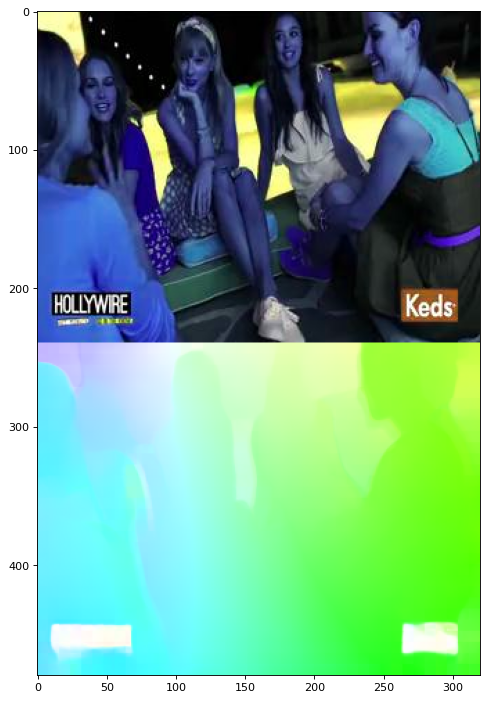

In [14]:
# Read extracted flow and RGB images, 20
idx = 0
video_idx = 'video1018' # 20
video_idx = 'video8481'  # 58

path = '/media/drive2/Data_4TB/MSRVTT/videos/frames/5fps/{}/'.format(video_idx)
image = os.path.join(path, 'frames/{}_{}.jpg'.format(video_idx, idx))
flow = np.load(os.path.join(path, 'optical_flows/{}.npy'.format(video_idx)))

img = cv2.imread(image)

_ = viz(load_image(img), torch.tensor(flow[idx]).permute(2, 0, 1).unsqueeze(0))

In [17]:
# Generate a gif for visualization
import imageio
images = []

# Read extracted flow and RGB images, 20
video_idx = 'video8481'  # 58

path = '/media/drive2/Data_4TB/MSRVTT/videos/frames/5fps/{}/'.format(video_idx)
flow = np.load(os.path.join(path, 'optical_flows/{}.npy'.format(video_idx)))

# img = cv2.imread(image)
for idx in range(flow.shape[0]):
    
    if idx % 1 == 0:
        image = os.path.join(path, 'frames/{}_{}.jpg'.format(video_idx, 48))
        _ = viz(load_image(cv2.imread(image)), torch.tensor(flow[idx]).permute(2, 0, 1).unsqueeze(0), display=False)
        images.append(_ )
        print(idx, ' out of ', flow.shape[0])
    
imageio.mimsave('{}.gif'.format(video_idx), images)

0  out of  48
1  out of  48
2  out of  48
3  out of  48
4  out of  48
5  out of  48
6  out of  48
7  out of  48
8  out of  48
9  out of  48
10  out of  48
11  out of  48
12  out of  48
13  out of  48
14  out of  48
15  out of  48
16  out of  48
17  out of  48
18  out of  48
19  out of  48
20  out of  48
21  out of  48
22  out of  48
23  out of  48
24  out of  48
25  out of  48
26  out of  48
27  out of  48
28  out of  48
29  out of  48
30  out of  48
31  out of  48
32  out of  48
33  out of  48
34  out of  48
35  out of  48
36  out of  48
37  out of  48
38  out of  48
39  out of  48
40  out of  48
41  out of  48
42  out of  48


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


43  out of  48
44  out of  48
45  out of  48
46  out of  48
47  out of  48


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0